In [ ]:
# l5kit dependencies
!pip install pymap3d==2.1.0 -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install protobuf==3.12.2 -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install transforms3d -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install zarr -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install ptable -i https://pypi.tuna.tsinghua.edu.cn/simple

# !pip uninstall -y typing

# The modified l5kit from my github repo (gpu branch)
# !pip install --no-dependencies git+https://github.com/pestipeti/lyft-l5kit.git@gpu#subdirectory=l5kit

In [ ]:
!pip install --no-dependencies git+https://github.com/pestipeti/lyft-l5kit.git@gpu

In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
# import l5kit

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm.notebook import tqdm
from typing import Dict

from torch.utils.cpp_extension import load, load_inline, is_ninja_available
from torch.utils.data._utils.collate import default_collate

from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.data.map_api import MapAPI
from l5kit.data.filter import (filter_agents_by_labels,
                               filter_agents_by_track_id,
                               filter_tl_faces_by_status)
from l5kit.dataset import AgentDataset,EgoDataset
from l5kit.evaluation import write_pred_csv
from l5kit.geometry import transform_points, rotation33_as_yaw, transform_point
from l5kit.rasterization import build_rasterizer, Rasterizer, RenderContext
from l5kit.rasterization.box_rasterizer import get_ego_as_agent
from l5kit.rasterization.semantic_rasterizer import elements_within_bounds
from l5kit.rasterization.rasterizer_builder import (_load_metadata,
                                                    get_hardcoded_world_to_ecef)

from typing import List, Optional, Tuple, Union

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"Is Ninja build available: {is_ninja_available()}")
# print(f"L5Kit version: {l5kit.__version__}")

PyTorch version: 1.8.1+cu102
Is Ninja build available: True


In [ ]:
!echo $PATH

In [ ]:
!unset PATH
!export PATH=/home/hrd/bin:/home/hrd/.local/bin:/home/hrd/workspace/anaconda3/bin:/home/hrd/workspace/anaconda3/condabin:/usr/local/cuda-10.2/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin

In [3]:
# make sure that we use cuda 10.2 here!
!echo $PATH

/home/hrd/bin:/home/hrd/.local/bin:/home/hrd/workspace/anaconda3/envs/l5gpu/bin:/home/hrd/workspace/anaconda3/condabin:/usr/local/cuda-10.2/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [4]:
lyft_gpu_cpp_src = """
#include <torch/extension.h>
#include <vector>
#include <iostream>

using namespace std;

/**
 * CUDA rasterize
 *
 * @param target torch.cuda.FloatTensor, shape: BxCxHxW (Batch, channels, height, width)
 * @param lines torch.cuda.FloatTensor List of lines to be drawn, shape: Nx7
 * @param agents torch.cuda.FloatTensor List of agents to be drawn, shape: Nx9
 * @param w2i torch.cuda.FloatTensor World to Image transformation matrices, shape: Bx3x3
 *
 * @return void
 */
void cuda_rasterize(torch::Tensor &target, torch::Tensor &lines, torch::Tensor &agents, torch::Tensor &w2i);

// Basic checks
#define CHECK_CUDA(x) TORCH_CHECK(x.is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

void rasterize(torch::Tensor &target, torch::Tensor &lines, torch::Tensor &agents, torch::Tensor &w2i) {

    // Run some checks.
    CHECK_INPUT(target);
    CHECK_INPUT(agents);
    CHECK_INPUT(lines);
    CHECK_INPUT(w2i);

    cuda_rasterize(target, lines, agents, w2i);
}

"""

In [5]:
lyft_gpu_cuda_src = """
#include <torch/extension.h>

#include <stdio.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <vector>

using namespace std;
using namespace torch::indexing;

namespace {

template <typename scalar_t>
__global__ void cuda_draw_lines_kernel(
    torch::PackedTensorAccessor32<scalar_t, 4, torch::RestrictPtrTraits> target,
    torch::PackedTensorAccessor32<scalar_t, 2, torch::RestrictPtrTraits> lines,
    size_t lines_size) {

    int batch_size = target.size(0);
    int channels = target.size(1);
    int height = target.size(2);
    int width = target.size(3);

    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;

    int dx, dy, dx1, dy1, px, py, xe, ye, x, y;
    int bx, x1, x2, y1, y2, ch, vl;

    for (int i = index; i < lines_size; i += stride) {

        bx = lines[i][0]; // batch idx
        x1 = lines[i][1]; // x1
        y1 = lines[i][2]; // y1
        x2 = lines[i][3]; // x2
        y2 = lines[i][4]; // y2
        ch = lines[i][5]; // channel idx (0-2: RGB)
        vl = lines[i][6]; // pixel value (0..255)

        /*
            The line drawing algorithm is from this post:
            https://jstutorial.medium.com/how-to-code-your-first-algorithm-draw-a-line-ca121f9a1395
        */

        dx = x2 - x1;
        dy = y2 - y1;

        dx1 = std::abs(dx);
        dy1 = std::abs(dy);

        px = 2 * dy1 - dx1;
        py = 2 * dx1 - dy1;

        // The line is X-axis dominant
        if (dy1 <= dx1) {

            if (dx >= 0) {
                // Line is drawn left to right
                x = x1; y = y1; xe = x2;
            } else {
                // Line is drawn right to left (swap ends)
                x = x2; y = y2; xe = x1;
            }

            if (x >= 0 && x < width && y >= 0 && y < height) {
                target[bx][ch][y][x] = vl;
            }

            while (x < xe) {
                x = x + 1;

                if (px < 0) {
                    px = px + 2 * dy1;
                } else {
                    if ((dx < 0 && dy < 0) || (dx > 0 && dy > 0)) {
                        y = y + 1;
                    } else {
                        y = y - 1;
                    }
                    px = px + 2 * (dy1 - dx1);
                }

                if (x >= 0 && x < width && y >= 0 && y < height) {
                    target[bx][ch][y][x] = vl;
                }
            }

        } else {

            if (dy >= 0) {
                // Line is drawn bottom to top
                x = x1; y = y1; ye = y2;
            } else {
                // Line is drawn top to bottom
                x = x2; y = y2; ye = y1;
            }

            if (x >= 0 && x < width && y >= 0 && y < height) {
                target[bx][ch][y][x] = vl;
            }

            while(y < ye) {
                y = y + 1;

                if (py <= 0) {
                    py = py + 2 * dx1;
                } else {
                    if ((dx < 0 && dy<0) || (dx > 0 && dy > 0)) {
                        x = x + 1;
                    } else {
                        x = x - 1;
                    }
                    py = py + 2 * (dx1 - dy1);
                }

                if (x >= 0 && x < width && y >= 0 && y < height) {
                    target[bx][ch][y][x] = vl;
                }

            }
        }//_else

    }//_for

}

template <typename scalar_t>
__global__ void cuda_generate_box_coords(
    torch::PackedTensorAccessor32<scalar_t, 2, torch::RestrictPtrTraits> agents,
    torch::PackedTensorAccessor32<scalar_t, 3, torch::RestrictPtrTraits> box_coords,
    torch::PackedTensorAccessor32<scalar_t, 3, torch::RestrictPtrTraits> transformations,
    torch::PackedTensorAccessor32<scalar_t, 3, torch::RestrictPtrTraits> centroids,
    size_t agents_size) {
    
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;
    
    float sy, cy, extent_l, extent_w;
    
    for (int i = index; i < agents_size; i += stride) {
        
        extent_l = agents[i][3] / 2;
        extent_w = agents[i][4] / 2;
        
        // Top-left (p1)
        box_coords[i][0][0] = -extent_l;
        box_coords[i][1][0] = -extent_w;
        box_coords[i][2][0] = 0.0;
        // Bottom-left (p2)
        box_coords[i][0][1] = -extent_l;
        box_coords[i][1][1] = extent_w;
        box_coords[i][2][1] = 0.0;
        // Bottom-right (p3)
        box_coords[i][0][2] = extent_l;
        box_coords[i][1][2] = extent_w;
        box_coords[i][2][2] = 0.0;
        // Top-right (p4)
        box_coords[i][0][3] = extent_l;
        box_coords[i][1][3] = -extent_w;
        box_coords[i][2][3] = 0.0;
        
        // agnet's yaw
        cy = cos(agents[i][6]);
        sy = sin(agents[i][6]);        
        
        transformations[i][0][0] = cy;
        transformations[i][0][1] = -sy;
        transformations[i][1][0] = sy;
        transformations[i][1][1] = cy;
        transformations[i][2][2] = 1.0;

        // agent's centroid xy (world space)
        centroids[i][0][0] = agents[i][1];
        centroids[i][1][0] = agents[i][2];
        centroids[i][2][0] = 1.0;
        centroids[i][0][1] = agents[i][1];
        centroids[i][1][1] = agents[i][2];
        centroids[i][2][1] = 1.0;
        centroids[i][0][2] = agents[i][1];
        centroids[i][1][2] = agents[i][2];
        centroids[i][2][2] = 1.0;
        centroids[i][0][3] = agents[i][1];
        centroids[i][1][3] = agents[i][2];
        centroids[i][2][3] = 1.0;

    }

}
    
template <typename scalar_t>
__global__ void cuda_world_to_image_transform(
    torch::PackedTensorAccessor32<scalar_t, 2, torch::RestrictPtrTraits> agents,
    torch::PackedTensorAccessor32<scalar_t, 3, torch::RestrictPtrTraits> w2i,
    torch::PackedTensorAccessor32<scalar_t, 3, torch::RestrictPtrTraits> transformations,
    size_t agents_size){
 
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;
    int bidx = 0;  // batch idx

    for (int i = index; i < agents_size; i += stride) {
        bidx = agents[i][0];

        transformations[i][0][0] = w2i[bidx][0][0];
        transformations[i][0][1] = w2i[bidx][0][1];
        transformations[i][0][2] = w2i[bidx][0][2];
        transformations[i][1][0] = w2i[bidx][1][0];
        transformations[i][1][1] = w2i[bidx][1][1];
        transformations[i][1][2] = w2i[bidx][1][2];
        transformations[i][2][0] = w2i[bidx][2][0];
        transformations[i][2][1] = w2i[bidx][2][1];
        transformations[i][2][2] = w2i[bidx][2][2];
    }

}
    
template <typename scalar_t>
__global__ void cuda_generate_rectangles(
    torch::PackedTensorAccessor32<scalar_t, 2, torch::RestrictPtrTraits> agents,
    torch::PackedTensorAccessor32<scalar_t, 3, torch::RestrictPtrTraits> box_coords,
    torch::PackedTensorAccessor32<scalar_t, 2, torch::RestrictPtrTraits> lines,
    size_t agents_size) {

    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;
    
    int bi, ch, vl, p1, p2;

    for (int i = index; i < agents_size; i += stride) {
        bi = agents[i][0];
        ch = agents[i][7];
        vl = agents[i][8];
        
        for (int j = 0; j < 4; j++) {
            
            p1 = j;
            p2 = j + 1;
            
            if (p2 > 3) {
                p2 = 0;
            }
            
            lines[i * 4 + j][0] = bi;
            lines[i * 4 + j][1] = (int)box_coords[i][0][p1];
            lines[i * 4 + j][2] = (int)box_coords[i][1][p1];
            lines[i * 4 + j][3] = (int)box_coords[i][0][p2];
            lines[i * 4 + j][4] = (int)box_coords[i][1][p2];
            lines[i * 4 + j][5] = ch;  // channel
            lines[i * 4 + j][6] = vl;  // color
        }
        
    }
};
    

}//_namespace

// CUDA declarations
void cuda_rasterize(torch::Tensor &target, torch::Tensor &lines, torch::Tensor &agents, torch::Tensor &w2i) {

    const int blocks_size = 1024;
    const int line_blocks = (lines.size(0) + blocks_size - 1) / blocks_size;
    const int lines_size = lines.size(0);

    // 1, Draw lines
    AT_DISPATCH_FLOATING_TYPES(target.type(), "cuda_draw_lines", ([&] {
        cuda_draw_lines_kernel<scalar_t><<<line_blocks, blocks_size>>>(
            target.packed_accessor32<scalar_t, 4, torch::RestrictPtrTraits>(),
            lines.packed_accessor32<scalar_t, 2, torch::RestrictPtrTraits>(),
            lines_size
            );
      }));

    const int agents_size = agents.size(0);
    const int agent_blocks = (agents_size + blocks_size - 1) / blocks_size;

    auto options = torch::TensorOptions().dtype(torch::kFloat32).device(torch::kCUDA, 0).requires_grad(false);

    // 2, Convert box coordinates

    // 2.1. - Generate corners
    torch::Tensor boxes = torch::zeros({agents_size, 3, 4}, options);
    torch::Tensor transformations = torch::zeros({agents_size, 3, 3}, options);
    torch::Tensor centroids = torch::zeros({agents_size, 3, 4}, options);
    torch::Tensor borders = torch::zeros({agents_size * 4, 7}, options);

    AT_DISPATCH_FLOATING_TYPES(target.type(), "cuda_generate_box_coords", ([&] {
        cuda_generate_box_coords<scalar_t><<<agent_blocks, blocks_size>>>(
            agents.packed_accessor32<scalar_t, 2, torch::RestrictPtrTraits>(),
            boxes.packed_accessor32<scalar_t, 3, torch::RestrictPtrTraits>(),
            transformations.packed_accessor32<scalar_t, 3, torch::RestrictPtrTraits>(),
            centroids.packed_accessor32<scalar_t, 3, torch::RestrictPtrTraits>(),
            agents_size
        );
    }));

    // 2.2. - Transform boxes (rotate by agent's yaw)
    boxes = torch::matmul(transformations, boxes);

    // 2.3. - Move agents to its position in the world space.
    boxes = torch::add(boxes, centroids);

    // 2.4. - Transform from world to image coordinates
    transformations *= 0.0;
    AT_DISPATCH_FLOATING_TYPES(target.type(), "cuda_world_to_image_transform", ([&] {
        cuda_world_to_image_transform<scalar_t><<<agent_blocks, blocks_size>>>(
            agents.packed_accessor32<scalar_t, 2, torch::RestrictPtrTraits>(),
            w2i.packed_accessor32<scalar_t, 3, torch::RestrictPtrTraits>(),
            transformations.packed_accessor32<scalar_t, 3, torch::RestrictPtrTraits>(),
            agents_size
        );
    }));

    boxes = torch::matmul(transformations, boxes);

    // 2.5. - Generate border lines.
    borders.index_put_({Slice(None, None), 0}, -1);
    AT_DISPATCH_FLOATING_TYPES(target.type(), "cuda_generate_rectangles", ([&] {
        cuda_generate_rectangles<scalar_t><<<agent_blocks, blocks_size>>>(
            agents.packed_accessor32<scalar_t, 2, torch::RestrictPtrTraits>(),
            boxes.packed_accessor32<scalar_t, 3, torch::RestrictPtrTraits>(),
            borders.packed_accessor32<scalar_t, 2, torch::RestrictPtrTraits>(),
            agents_size
        );
    }));

    // 2.6. - Draw box border
    AT_DISPATCH_FLOATING_TYPES(target.type(), "cuda_draw_lines", ([&] {
        cuda_draw_lines_kernel<scalar_t><<<line_blocks, blocks_size>>>(
            target.packed_accessor32<scalar_t, 4, torch::RestrictPtrTraits>(),
            borders.packed_accessor32<scalar_t, 2, torch::RestrictPtrTraits>(),
            borders.size(0)
            );
    }));

    // 2.7. - Fill boxes.
    cudaDeviceSynchronize();
}
"""


In [6]:
lyft_gpu = load_inline(
    name='lyft_gpu_rasterizer',
    cpp_sources=[lyft_gpu_cpp_src],
    cuda_sources=[lyft_gpu_cuda_src],
    functions=['rasterize'],
    build_directory='./rastgpu',
    with_cuda=True,
    verbose=True
)


Detected CUDA files, patching ldflags
Emitting ninja build file ./rastgpu/build.ninja...
Building extension module lyft_gpu_rasterizer...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


/home/hrd/workspace/anaconda3/envs/l5gpu/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=lyft_gpu_rasterizer -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/hrd/workspace/anaconda3/envs/l5gpu/lib/python3.8/site-packages/torch/include -isystem /home/hrd/workspace/anaconda3/envs/l5gpu/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -isystem /home/hrd/workspace/anaconda3/envs/l5gpu/lib/python3.8/site-packages/torch/include/TH -isystem /home/hrd/workspace/anaconda3/envs/l5gpu/lib/python3.8/site-packages/torch/include/THC -isystem /usr/local/cuda-10.2/include -isystem /home/hrd/workspace/anaconda3/envs/l5gpu/include/python3.8 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++14 -c /home/autowise/data_ssd/hrd/l5kit/examples/planning/rastgpu/main.cpp -o main.o 
[2/3] /usr/local/cuda-10.2/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=lyft_gpu_rasterizer -DTORCH_API_

In [ ]:
!echo $PATH

In [20]:
# Lane-line colors
DIVIDER_TYPE_CODES = [128, 128, 16, 40, 64, 88, 112, 136, 160, 184, 208, 232, 255]

class GPURasterizer(Rasterizer):

    def __init__(self, raster_size: Tuple[int, int], pixel_size: Union[np.ndarray, list, float],
                 ego_center: np.ndarray, filter_agents_threshold: float, history_num_frames: int,
                 semantic_map_path: str, world_to_ecef: np.ndarray):
        super().__init__()

        self.raster_size = np.array(raster_size)
        self.pixel_size = np.array(pixel_size)
        self.ego_center = ego_center
        self.filter_agents_threshold = filter_agents_threshold
        self.history_num_frames = history_num_frames
        self.world_to_ecef = world_to_ecef
        self.proto_API = MapAPI(semantic_map_path, world_to_ecef)
        
        self.render_context = RenderContext(
            raster_size_px=self.raster_size,
            pixel_size_m=self.pixel_size,
            center_in_raster_ratio=self.ego_center,
        )

        self.bounds_info = self.get_bounds()

    def get_bounds(self) -> dict:
        """
        For each elements of interest returns bounds [[min_x, min_y],[max_x, max_y]] and proto ids
        Coords are computed by the MapAPI and, as such, are in the world ref system.

        Returns:
            dict: keys are classes of elements, values are dict with `bounds` and `ids` keys
        """
        lanes_ids = []
        crosswalks_ids = []
        speedbumps_ids = []
        speedhumps_ids = []

        lanes_bounds = np.empty((0, 2, 2), dtype=np.float64)  # [(X_MIN, Y_MIN), (X_MAX, Y_MAX)]
        crosswalks_bounds = np.empty((0, 2, 2), dtype=np.float64)  # [(X_MIN, Y_MIN), (X_MAX, Y_MAX)]
        speedbumps_bounds = np.empty((0, 2, 2), dtype=np.float64)  # [(X_MIN, Y_MIN), (X_MAX, Y_MAX)]
        speedhumps_bounds = np.empty((0, 2, 2), dtype=np.float64)  # [(X_MIN, Y_MIN), (X_MAX, Y_MAX)]

        for element in self.proto_API:
            element_id = MapAPI.id_as_str(element.id)

            if self.proto_API.is_lane(element):
                lane = self.proto_API.get_lane_coords(element_id)
                x_min = np.min(lane["xyz"][0, :])
                y_min = np.min(lane["xyz"][1, :])
                x_max = np.max(lane["xyz"][0, :])
                y_max = np.max(lane["xyz"][1, :])

                lanes_bounds = np.append(lanes_bounds, np.asarray([[[x_min, y_min], [x_max, y_max]]]), axis=0)
                lanes_ids.append(element_id)

            if self.proto_API.is_crosswalk(element):
                crosswalk = self.proto_API.get_crosswalk_coords(element_id)
                x_min = np.min(crosswalk["xyz"][0, :])
                y_min = np.min(crosswalk["xyz"][1, :])
                x_max = np.max(crosswalk["xyz"][0, :])
                y_max = np.max(crosswalk["xyz"][1, :])

                crosswalks_bounds = np.append(
                    crosswalks_bounds, np.asarray([[[x_min, y_min], [x_max, y_max]]]), axis=0,
                )
                crosswalks_ids.append(element_id)

            if self.proto_API.is_speedbump(element):
                speedbump = self.proto_API.get_speedbump_coords(element_id)
                x_min = np.min(speedbump["xyz"][0, :])
                y_min = np.min(speedbump["xyz"][1, :])
                x_max = np.max(speedbump["xyz"][0, :])
                y_max = np.max(speedbump["xyz"][1, :])

                speedbumps_bounds = np.append(
                    speedbumps_bounds, np.asarray([[[x_min, y_min], [x_max, y_max]]]), axis=0,
                )
                speedbumps_ids.append(element_id)

            if self.proto_API.is_speedhump(element):
                speedhump = self.proto_API.get_speedhump_coords(element_id)
                x_min = np.min(speedhump["xyz"][0, :])
                y_min = np.min(speedhump["xyz"][1, :])
                x_max = np.max(speedhump["xyz"][0, :])
                y_max = np.max(speedhump["xyz"][1, :])

                speedhumps_bounds = np.append(
                    speedhumps_bounds, np.asarray([[[x_min, y_min], [x_max, y_max]]]), axis=0,
                )
                speedhumps_ids.append(element_id)

        return {
            "lanes": {"bounds": lanes_bounds, "ids": lanes_ids},
            "crosswalks": {"bounds": crosswalks_bounds, "ids": crosswalks_ids},
            "speedbumps": {"bounds": speedbumps_bounds, "ids": speedbumps_ids},
            "speedhumps": {"bounds": speedhumps_bounds, "ids": speedhumps_ids},
        }

    def rasterize(self,
                  history_frames: np.ndarray,
                  history_agents: List[np.ndarray],
                  history_tl_faces: List[np.ndarray],
                  agent: Optional[np.ndarray] = None
                  ) -> Union[np.ndarray, dict]:

        if agent is None:
            ego_translation_m = history_frames[0]["ego_translation"]
            ego_yaw_rad = rotation33_as_yaw(history_frames[0]["ego_rotation"])
        else:
            ego_translation_m = np.append(agent["centroid"], history_frames[0]["ego_translation"][-1])
            ego_yaw_rad = agent["yaw"]

        raster_from_world = self.render_context.raster_from_world(ego_translation_m, ego_yaw_rad)
        world_from_raster = np.linalg.inv(raster_from_world)

        # get XY of center pixel in world coordinates
        center_in_raster_px = np.asarray(self.raster_size) * (0.5, 0.5)
        center_in_world_m = transform_point(center_in_raster_px, world_from_raster)
        
        # box_channels = (self.history_num_frames + 1) * 2
        # channels = box_channels + 3

        res = {
            "lines": self.generate_map_data(center_in_world_m, raster_from_world, history_tl_faces[0]),
            "agents": self.generate_agents(history_frames, history_agents, history_tl_faces,
                                           raster_from_world, agent),
            "raster_from_world": raster_from_world
        }

        return res

    def to_rgb(self, in_im: np.ndarray, **kwargs: dict) -> np.ndarray:
        #in_im  (35, 220, 350)
        out_im = in_im[0:3, ...].copy() * 255.0
        #out_im  (3, 220, 350)
        out_im = np.transpose(out_im, (1, 2, 0))
        #out_im  (220, 350, 3)

        out_im_agent = np.zeros((self.raster_size[1], self.raster_size[0], 3), dtype=np.float32)
        agent_chs = in_im[3:3+self.history_num_frames+1][::-1] # 遍历channel [3:19]
        agent_color = (0, 0, 255)
        for ch in agent_chs:
            out_im_agent *= 0.85
            out_im_agent[ch > 0] = agent_color

        out_im_ego = np.zeros((self.raster_size[1], self.raster_size[0], 3), dtype=np.float32)
        ego_chs = in_im[3+self.history_num_frames+1:][::-1] # [19:]
        ego_color = (0, 255, 0)

        for ch in ego_chs:
            out_im_ego *= 0.85
            out_im_ego[ch > 0] = ego_color

        out_box_im = (np.clip(out_im_agent + out_im_ego, 0, 255)).astype(np.uint8)

        mask_box = np.any(out_box_im > 0, -1)
        out_im[mask_box] = out_box_im[mask_box]
        out_im = out_im.astype(np.uint8)

        return out_im

    def generate_map_data(self, center_world: np.ndarray, world_to_image_space: np.ndarray,
                          tl_faces: np.ndarray) -> Union[np.ndarray, dict]:
        '''
        将lane，crosswalk，speedbumps&hump转换成gpu rasterizer使用的数据结构:
        先用elements_within_bounds提取一定范围内的元素index，再用self.proto_API根据index从数据库中提取坐标
        等信息作处理，最后所有类型统一np.concatenate(res)封装到一起
        '''

        # filter using half a radius from the center
        raster_radius = float(np.linalg.norm(self.raster_size * self.pixel_size)) / 2

        # get active traffic light faces
        # 提取道路红绿灯状态用于道路渲染
        active_tl_ids = set(filter_tl_faces_by_status(tl_faces, "ACTIVE")["face_id"].tolist())

        res = []
        lane_ids = []
        tls = {}
        for idx in elements_within_bounds(center_world, self.bounds_info["lanes"]["bounds"], raster_radius):
            lane_id = self.bounds_info["lanes"]["ids"][idx]
            lane = self.proto_API[lane_id].element.lane

            # no traffic light face is controlling
            # this lane (blue channel 128 pixel value)
            # 设定道路渲染颜色
            lane_type = [2, 128]
            tl = 0

            # 去掉重复lane id
            lane_tl_ids = set([MapAPI.id_as_str(la_tc) for la_tc in lane.traffic_controls])

            for tl_id in lane_tl_ids.intersection(active_tl_ids):
                if self.proto_API.is_traffic_face_colour(tl_id, "red"):
                    lane_type = [0, 255]
                    tl = 1
                elif self.proto_API.is_traffic_face_colour(tl_id, "green"):
                    lane_type = [1, 255]
                    tl = 2
                elif self.proto_API.is_traffic_face_colour(tl_id, "yellow"):
                    lane_type = [1, 128]
                    tl = 3

            lane_coords = self.proto_API.get_lane_coords(lane_id)
            lanes_xy = world_to_image_space.dot(lane_coords["xyz"]).T[:, :2]

            lanes = np.zeros(shape=(len(lanes_xy) - 1, 7), dtype=np.float32)
            # batch index. When the DataLoader loads the data (in parallel), 
            # this is unknown. Later, the collate_fn will fill this 
            lanes[:, 0] = 0
    
            lanes[:, 5] = lane_type[0]  # channel
            lanes[:, 6] = lane_type[1]  # Channel value (0..255; technically it can be any number)

            if lane_type[0] == 2:
                # no traffic light -> lane boundary type encode
                ln = lane_coords["left_point_num"]# 左右边界点的index界限点
                left_type = lane_coords["left_divider_type"]
                right_type = lane_coords["right_divider_type"]

                if left_type > 12:
                    left_type = 0

                if right_type > 12:
                    right_type = 0

                lanes[:ln, 6] = DIVIDER_TYPE_CODES[left_type]# Channel value
                lanes[ln:, 6] = DIVIDER_TYPE_CODES[right_type]# Channel value

            lanes[:, 1:3] = lanes_xy[:-1, 0:2]# x1, y1
            lanes[:, 3:5] = lanes_xy[1:, 0:2]# x2, y2

            res.append(lanes)

        for idx in elements_within_bounds(center_world, self.bounds_info["crosswalks"]["bounds"], raster_radius):
            crosswalk = self.proto_API.get_crosswalk_coords(self.bounds_info["crosswalks"]["ids"][idx])

            cross_xy = world_to_image_space.dot(crosswalk["xyz_t"]).T[:, :2]

            crosswalks = np.zeros(shape=(len(cross_xy), 7), dtype=np.float32)
            crosswalks[:, 0] = 0
            crosswalks[:, 5] = 0 # crosswalks和交通灯red相同
            crosswalks[:, 6] = 128

            crosswalks[:-1, 1:3] = cross_xy[:-1, 0:2]
            crosswalks[:-1, 3:5] = cross_xy[1:, 0:2]

            # "Polygon" closing line
            crosswalks[-1, 1:3] = cross_xy[-1, 0:2]
            crosswalks[-1, 3:5] = cross_xy[0, 0:2]

            res.append(crosswalks)

        for idx in elements_within_bounds(center_world, self.bounds_info["speedbumps"]["bounds"], raster_radius):
            speedbumps = self.proto_API.get_speedbump_coords(self.bounds_info["speedbumps"]["ids"][idx])

            cross_xy = world_to_image_space.dot(speedbumps["xyz"]).T[:, :2]

            speedbumps = np.zeros(shape=(len(cross_xy), 7), dtype=np.float32)
            speedbumps[:, 0] = 0
            speedbumps[:, 5] = 1
            speedbumps[:, 6] = 128

            speedbumps[:-1, 1:3] = cross_xy[:-1, 0:2]
            speedbumps[:-1, 3:5] = cross_xy[1:, 0:2]

            # "Polygon" closing line
            speedbumps[-1, 1:3] = cross_xy[-1, 0:2]
            speedbumps[-1, 3:5] = cross_xy[0, 0:2]

            res.append(speedbumps)
            
        for idx in elements_within_bounds(center_world, self.bounds_info["speedhumps"]["bounds"], raster_radius):
            speedhumps = self.proto_API.get_speedhump_coords(self.bounds_info["speedhumps"]["ids"][idx])

            cross_xy = world_to_image_space.dot(speedhumps["xyz"]).T[:, :2]

            speedhumps = np.zeros(shape=(len(cross_xy), 7), dtype=np.float32)
            speedhumps[:, 0] = 0
            speedhumps[:, 5] = 1
            speedhumps[:, 6] = 64

            speedhumps[:-1, 1:3] = cross_xy[:-1, 0:2]
            speedhumps[:-1, 3:5] = cross_xy[1:, 0:2]

            # "Polygon" closing line
            speedhumps[-1, 1:3] = cross_xy[-1, 0:2]
            speedhumps[-1, 3:5] = cross_xy[0, 0:2]

            res.append(speedhumps)

        return np.concatenate(res) if len(res) > 0 else np.array([])

    def generate_agents(self, history_frames: np.ndarray, history_agents: List[np.ndarray],
                        history_tl_faces: List[np.ndarray], world_to_image_space: np.ndarray,
                        agent: Optional[np.ndarray] = None):

        nframes = len(history_frames)
        boxes = []

        for i, (frame, agents) in enumerate(zip(history_frames, history_agents)):
            # 所有agent都会被感知模块在不同的标签上打上相应的概率，在filter_agents_by_labels中选取
            # 感兴趣的标签子集，计算这些子集对应的概率之和，如果其概率和大于threshold，则此障碍物会被当成场景中的agent提取出来
            agents = filter_agents_by_labels(agents, self.filter_agents_threshold)
            av_agent = get_ego_as_agent(frame).astype(agents.dtype)

            # 轨迹渲染颜色根据时间fading，调整self.generate_box_data()最后一个参数
            if agent is None:# 没有指定某个agent为ego，默认数据集的ego
                # generate agents
                self.generate_box_data(boxes, agents, 3 + i, 255)

                # generate av_agent (ego)
                self.generate_box_data(boxes, av_agent, 3 + nframes + i, 255)
            else:
                agent_ego = filter_agents_by_track_id(agents, agent["track_id"])

                if len(agent_ego) == 0:  # Agent not in this history frame
                    # generate agents
                    self.generate_box_data(boxes, np.append(agents, av_agent), 3 + i, 255)

                else:  # Add AV to agents and remove the agent from agents
                    agents = agents[agents != agent_ego[0]]

                    # generate agents
                    self.generate_box_data(boxes, np.append(agents, av_agent), 3 + i, 255)

                    # generate agent (ego)
                    self.generate_box_data(boxes, agent_ego, 3 + nframes + i, 255)

        return np.array(boxes)

    def generate_box_data(self, boxes, agents, channel_id, value):
        '''
        根据感知类型整理几何边界，同时将agent的数据结构整理成新格式
        '''

        for idx, agent in enumerate(agents):
            extent = agent["extent"]

            if agent["label_probabilities"][3] == 1:
                # Car - minimum extent..
                # EGO_EXTENT_WIDTH = 1.85
                # EGO_EXTENT_LENGTH = 4.87
                extent[0] = max(3, extent[0])
                extent[1] = max(1.4, extent[1])

            elif agent["label_probabilities"][12] == 1:
                # Cyclists
                extent[0] = max(1.3, extent[0])
                extent[1] = max(0.5, extent[1])

            if agent["label_probabilities"][14] == 1:
                # Increase the pedestrians "size"
                extent = extent * 1.8
            else:
                extent = extent

            boxes.append((
                0,  # Batch index (filled later)

                agent["centroid"][0],  # c_x
                agent["centroid"][1],  # c_y

                extent[0],  # Length
                extent[1],  # Width
                extent[2],  # Height
                agent["yaw"],  # yaw

                channel_id,
                value
            ))

In [8]:
# benchmarks
os.environ["L5KIT_DATA_FOLDER"] = "./l5kit_data"
dm = LocalDataManager(None)

cfg = {
    'format_version': 4,
    'model_params': {
        'history_num_frames': 15,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1
    },
    
    'raster_params': {
        'raster_size': [350, 220],
        'pixel_size': [0.4, 0.4],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5,
        'disable_traffic_light_faces': False
    },
    
    'train_data_loader': {
        'key': 'scenes/sample.zarr',
#         'key': 'scenes/train_full.zarr',
        'batch_size': 12,
        'shuffle': False,
        'num_workers': 4
    }

}

In [9]:
def build_model(cfg: Dict) -> torch.nn.Module:
    # load pre-trained Conv2D model
    model = resnet50(pretrained=False)

    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model

def forward(data, model, device):
    inputs = data["image"].permute(0, 3, 1, 2).to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    return outputs

In [10]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]

train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()

rasterizer = build_rasterizer(cfg, dm)

train_dataset = EgoDataset(cfg, train_zarr, rasterizer)
# train_dataset = AgentDataset(cfg, train_zarr, rasterizer)

train_dataloader = DataLoader(train_dataset,
                              shuffle=train_cfg["shuffle"],
                              batch_size=train_cfg["batch_size"],
                              num_workers=train_cfg["num_workers"])

# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model(cfg).to(device)

In [11]:
# progress_bar = tqdm(train_dataloader, total=100)
# model.train()

# for itr, data in enumerate(progress_bar):
    
#     outputs = forward(data, model, device)
#     # Skip the rest of the training...
    
#     if itr == 100:
#         break

In [12]:
def lyft_gpu_collate_fn(batch):
    element = batch[0]

    rasterizer_args = [
        "lines",
        "agents"
    ]

    result = {
        key: default_collate([d[key] for d in batch]) for key in element if key not in rasterizer_args
    }

    for element in batch:

        for rasterizer_arg in rasterizer_args:
            if rasterizer_arg not in result:
                result[rasterizer_arg] = []

            result[rasterizer_arg].append(element[rasterizer_arg])
            
    # 添加上batch index
    for bidx in range(len(result["lines"])):
        result["lines"][bidx][:, 0] = bidx

    for bidx in range(len(result["agents"])):
        result["agents"][bidx][:, 0] = bidx

    result["lines"] = torch.from_numpy(np.concatenate(result["lines"]))
    result["agents"] = torch.from_numpy(np.concatenate(result["agents"]))

    return result

In [13]:
raster_cfg = cfg["raster_params"]
model_cfg = cfg["model_params"]
train_cfg = cfg['train_data_loader']

semantic_map_filepath = dm.require(raster_cfg["semantic_map_key"])

try:
    dataset_meta = _load_metadata(raster_cfg["dataset_meta_key"], dm)
    world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
except (KeyError, FileNotFoundError):
    world_to_ecef = get_hardcoded_world_to_ecef()

data_rasterizer = GPURasterizer(
    raster_size=raster_cfg["raster_size"],
    pixel_size=raster_cfg["pixel_size"],
    ego_center=raster_cfg["ego_center"],
    filter_agents_threshold=0.5,
    history_num_frames=cfg["model_params"]["history_num_frames"],
    semantic_map_path=semantic_map_filepath,
    world_to_ecef=world_to_ecef,
)

In [14]:
def forward_gpu(data, model, device, cuda_generator):
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    matrix = data["raster_from_world"].to(device).to(torch.float)
    
    data["lines"] = data["lines"].to(device).type(torch.cuda.FloatTensor)
    data["agents"] = data["agents"].to(device).type(torch.cuda.FloatTensor)
    
#     np_image = data["image"].cpu().numpy()
#     print('before',np.any(np_image > 0)) # False
    
    cuda_generator.rasterize(data["image"], data["lines"], data["agents"], matrix)
    
#     np_image = data["image"].cpu().numpy()
#     print('after',np.any(np_image > 0)) # True
    
    data["image"] /= 255.
    
    
    last_batch = False
    if len(data["image"]) != len(targets):
        # Last batch
        last_batch = len(targets)    
    
    # Forward pass
    outputs = model(data["image"] if not last_batch else data["image"][:last_batch, ...]).reshape(targets.shape)
    
    return outputs


In [15]:
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open(cached=True)

train_dataset = EgoDataset(cfg, train_zarr, data_rasterizer)
# train_dataset = AgentDataset(cfg, train_zarr, data_rasterizer)

train_dataloader = DataLoader(train_dataset,
                              collate_fn=lyft_gpu_collate_fn,
                              shuffle=train_cfg["shuffle"],
                              batch_size=train_cfg["batch_size"],
                              num_workers=train_cfg["num_workers"],
                              drop_last=True)

channels = ((cfg["model_params"]["history_num_frames"] + 1) * 2) + 3

images = torch.zeros((train_cfg["batch_size"],
                      channels,
                      raster_cfg["raster_size"][1],
                      raster_cfg["raster_size"][0]))

images = images.to(device).type(torch.cuda.FloatTensor)
print(train_dataset)
print(type(images))

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
<class 'torch.Tensor'>


In [19]:
progress_bar = tqdm(train_dataloader)
model.train()

dataset = []
imageset = []
rgb_imageset = []

for itr, data in enumerate(progress_bar):

    data["image"] = images
    data["image"] *= 0    # 重置data["image"]片内存上信息
    
    outputs = forward_gpu(data, model, device, lyft_gpu)
    #直接append data
#     dataset.append(data)
    
    # 单独image转移到cpu image为不同图像 每个item为一个batch集合
    # batch_size * (channel * (image_size))
    # 破坏训练管道，导致效率降低不可用
    # 实验1： dataset为EGO train_full: 80G 
    # 51 * batch_size * (channel * (image_size)) 内存占用10G
    # batch_size = 12，channel = 35 image_size = 220*350
    # 共处理frame = 51 *12 = 612
    # train_full batch_size下需要 2786421 iters
    # 处理完sample.zarr产生image数据: 2786421iters*(10G/51iters) = 546357G = 533T
    # 膨胀比为 546357G/80G = 6829
    
    # 实验2： dataset为Agent sample.zarr: 50M 
    # 51 * batch_size * (channel * (image_size)) 内存占用9G
    # batch_size = 12，channel = 35 image_size = 220*350
    # 共处理frame = 51 *12 = 612
    # train_full batch_size下需要 9302 iters
    # 处理完sample.zarr产生image数据: 9302iters*(9G/51iters) = 1641.5G 
    
    # 实验3： dataset为Ego sample.zarr: 50M 
    # 51 * batch_size * (channel * (image_size)) 内存占用9G
    # batch_size = 12，channel = 35 image_size = 220*350
    # 共处理frame = 51 *12 = 612
    # train_full batch_size下需要 2069 iters
    # 处理完sample.zarr产生image数据: 2069iters*(9G/51iters) = 365G 

    
    image = data["image"].data.cpu().numpy()
    imageset.append(image)
    for im in image:
        rgb_imageset.append(data_rasterizer.to_rgb(im))
    # Skip the rest of the training...
#     if itr == 1 or itr == 10:
#         print(itr)
#         img = data_rasterizer.to_rgb(data["image"][1].data.cpu().numpy())

#         plt.imshow(img[::-1])
    
    if itr == 10:
        break
    



  0%|          | 0/2069 [00:00<?, ?it/s]

ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 22

ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 22

132


<IPython.core.display.Javascript object>


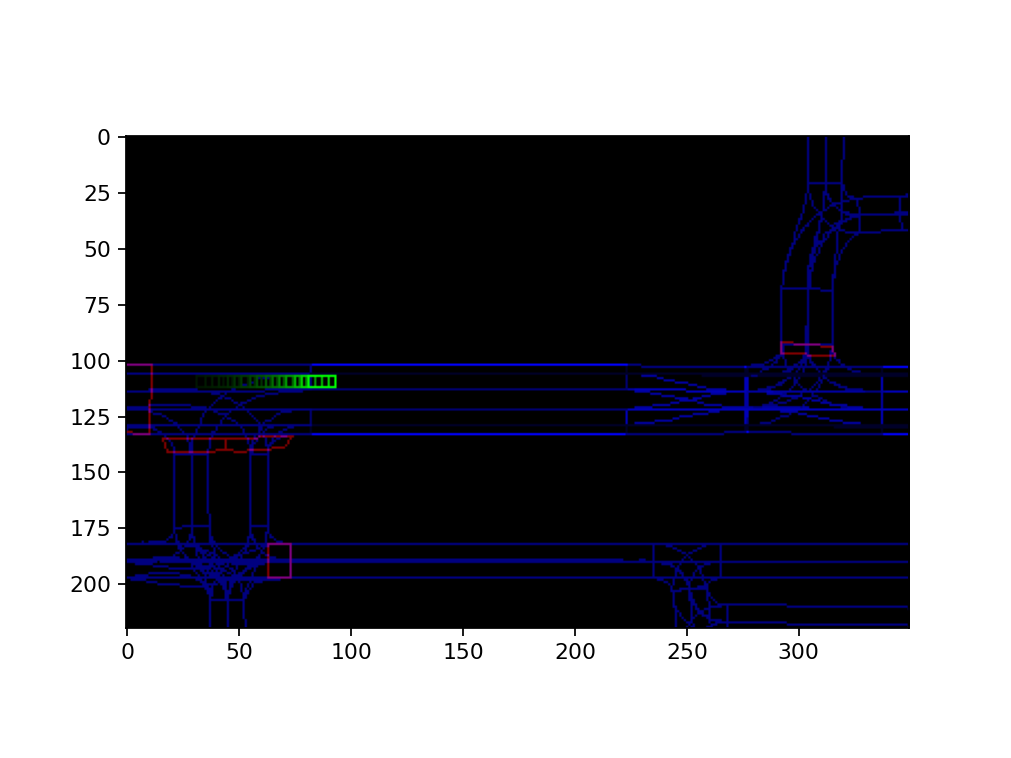

In [22]:
print(len(rgb_imageset))
%matplotlib notebook
plt.imshow(rgb_imageset[131])

<class 'numpy.ndarray'>
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)


<IPython.core.display.Javascript object>


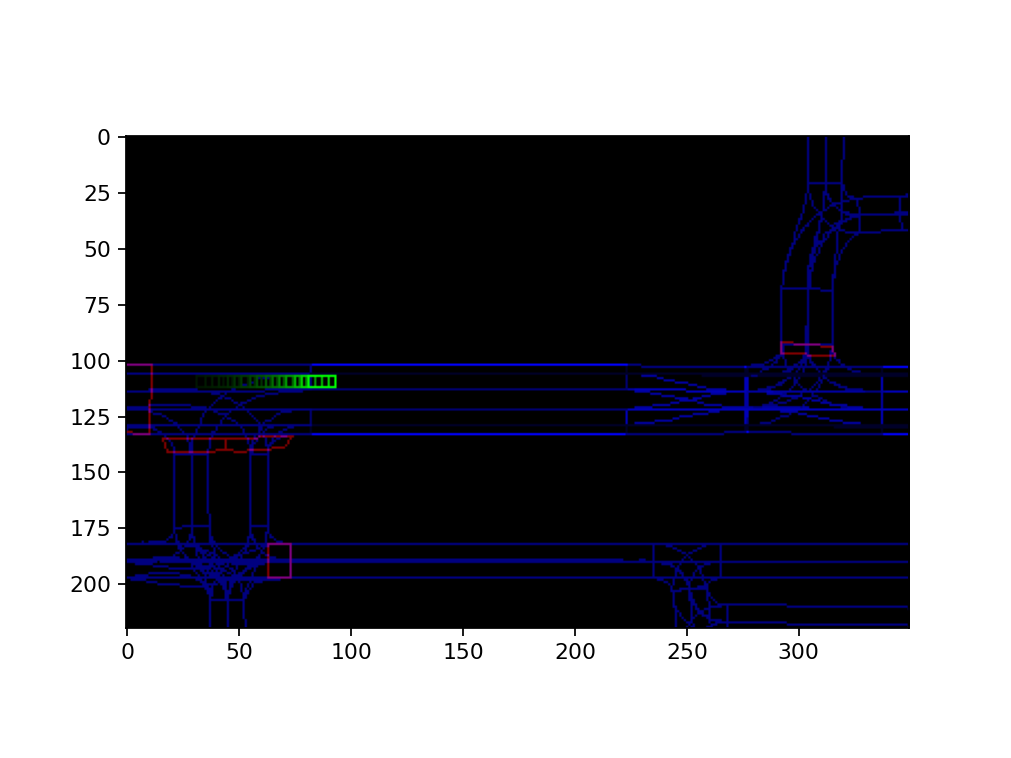

In [30]:
print(type(data["image"].data.cpu().numpy()))
# print(data["image"].data.cpu().numpy()[11])
%matplotlib notebook
plt.imshow(data_rasterizer.to_rgb(data["image"].data.cpu().numpy()[11]))

51
data shape in every batch (12, 35, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
<class 'numpy.ndarray'>


<IPython.core.display.Javascript object>


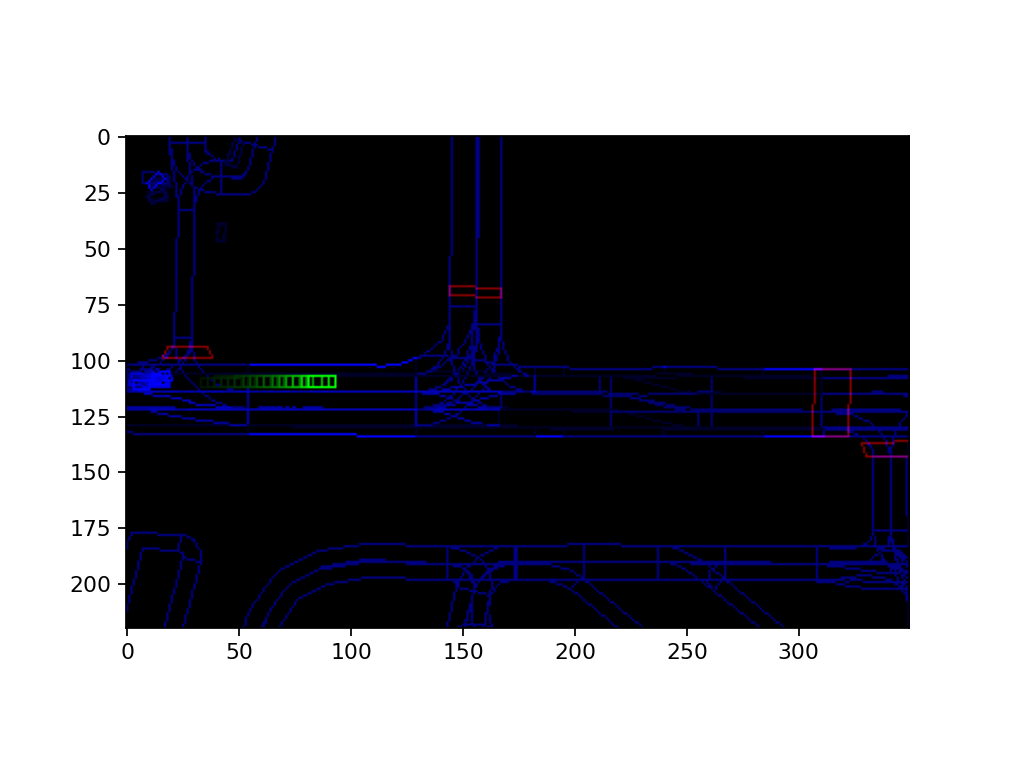

ego_chs: <class 'numpy.ndarray'> (16, 220, 350)
ego_chs: <class 'numpy.ndarray'> (16, 220, 350)


In [18]:
print(len(imageset))
print("data shape in every batch",imageset[0].shape)
batch_data = imageset[3]
dataset_img1 = data_rasterizer.to_rgb(batch_data[0]) # 0-35
print(type(dataset_img1))
%matplotlib notebook
plt.imshow(dataset_img1[::-1])
plt.imshow(data_rasterizer.to_rgb(batch_data[2]))

In [ ]:
dataset_img10 = data_rasterizer.to_rgb(imageset[10][0])
%matplotlib notebook
plt.imshow(dataset_img10[::-1])

In [ ]:
print(len(dataset))
print(type(dataset[0]))
print(dataset[0].keys())
print(type(dataset[0]["image"]))
print(dataset[0]["image"].device)
print(dataset[0]['timestamp'])
# print(dataset[0]['yaw'])
# print(dataset[0]['centroid'])
print(data["image"][1].data.cpu().numpy().shape)
dataset_img1 = data_rasterizer.to_rgb(dataset[0]["image"][1].data.cpu().numpy())
plt.imshow(dataset_img1[::-1])

In [ ]:
print(dataset[10]['timestamp'])
print(dataset[10]['yaw'])
print(dataset[10]['centroid'])
dataset_img10 = data_rasterizer.to_rgb(dataset[10]["image"][1].data.cpu().numpy())
plt.imshow(dataset_img10[::-1])

In [ ]:
print(dataset[10]["image"].data.cpu().numpy().shape)

In [ ]:
img = data_rasterizer.to_rgb(data["image"][1].data.cpu().numpy())

plt.imshow(img[::-1])
plt.imshow(img[::-1])
# plt.imshow(img)
# model 断层
# data变量的赋值
# 保存形式，data所有数据

In [ ]:
plt.imshow(img)

In [ ]:
print(type(data))
print(type(data["image"][1]))
print(data.keys())
print(data["image"][1].shape) # (history_num_frames+1)*2+3 raster_size
print(type(data["image"][1].data)) 
# for key, data in data.items(): type(data) in data are all torch.Tensor
#     print(type(data))